# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '04'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

fname1=mdir+edir+'icebox_train_rc.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 1956367)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 22:04:39 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_snow.values
    n_s  = xr.open_dataset(fname).n_snow.values
    # reflectivity
    z_s  = xr.open_dataset(fname).z_snow.values
    # some numerical lower bounds
    q_min = 1e-20
    n_min = 1e-20
    z_min = 1e-20
    p_min = 1e-20
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    z_s = np.log(z_s, where=z_s>q_min, out=np.nan*n_s)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ z_s, q_s, n_s, temp, rho ]))
    dataset = dataset.T
    dataset.columns = [ 'z_s', 'q_s', 'n_s', 'temp', 'rho' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

In [8]:
df.describe()

z_s           q_s           n_s          temp           rho
count  1.682420e+06  1.682420e+06  1.682420e+06  1.682420e+06  1.682420e+06
mean  -2.726907e+01 -9.028294e+00  1.050651e+01  2.415397e+02  6.912739e-01
std    6.473030e+00  2.984802e+00  3.513880e+00  1.375014e+01  1.717041e-01
min   -4.605160e+01 -2.954664e+01 -1.449861e+01  2.066400e+02  4.120000e-01
25%   -3.134104e+01 -1.010113e+01  9.768354e+00  2.315600e+02  5.620000e-01
50%   -2.819894e+01 -8.519646e+00  1.135538e+01  2.409900e+02  6.680000e-01
75%   -2.392858e+01 -7.124668e+00  1.260197e+01  2.499300e+02  7.800000e-01
max    5.226016e+00 -4.005400e+00  1.608032e+01  2.857000e+02  1.289000e+00

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

z_s        q_s       n_s        temp    rho
0 -31.548912 -12.639598  6.654152  245.710007  0.697
1 -31.349123 -12.453713  6.839477  245.770004  0.697
2 -31.189575 -12.302848  6.967909  245.820007  0.698
3 -30.974781 -12.152892  7.106606  245.869995  0.699
4 -30.811493 -12.012647  7.238497  245.929993  0.699

In [11]:
dataset_train.describe()

z_s           q_s           n_s          temp           rho
count  1.177533e+06  1.177533e+06  1.177533e+06  1.177533e+06  1.177533e+06
mean  -2.726889e+01 -9.028231e+00  1.050683e+01  2.415432e+02  6.912865e-01
std    6.473533e+00  2.987174e+00  3.517509e+00  1.375041e+01  1.717256e-01
min   -4.605160e+01 -2.954664e+01 -1.449861e+01  2.066400e+02  4.120000e-01
25%   -3.134117e+01 -1.010065e+01  9.770413e+00  2.315600e+02  5.620000e-01
50%   -2.819849e+01 -8.518144e+00  1.135763e+01  2.410000e+02  6.680000e-01
75%   -2.393162e+01 -7.123415e+00  1.260408e+01  2.499400e+02  7.800000e-01
max    5.226016e+00 -4.005400e+00  1.608032e+01  2.857000e+02  1.289000e+00

In [12]:
dataset_test.describe()

z_s            q_s            n_s           temp  \
count  252764.000000  252764.000000  252764.000000  252764.000000   
mean      -27.279634      -9.034801      10.502797     241.534348   
std         6.475849       2.984893       3.504986      13.728722   
min       -46.050602     -28.530405     -14.498609     206.789993   
25%       -31.358485     -10.112734       9.763981     231.589996   
50%       -28.220322      -8.529721      11.345027     240.979996   
75%       -23.906425      -7.127916      12.591896     249.889999   
max         5.161753      -4.008039      16.023642     283.940002   

                 rho  
count  252764.000000  
mean        0.691222  
std         0.171416  
min         0.413000  
25%         0.563000  
50%         0.668000  
75%         0.780000  
max         1.277000

In [13]:
dataset_val.describe()

z_s            q_s            n_s           temp  \
count  252123.000000  252123.000000  252123.000000  252123.000000   
mean      -27.259327      -9.022054      10.508760     241.528488   
std         6.467859       2.973602       3.505829      13.770400   
min       -46.051102     -26.775585     -14.467842     206.740005   
25%       -31.323828     -10.092097       9.771555     231.529999   
50%       -28.181940      -8.516793      11.353976     240.979996   
75%       -23.941430      -7.127847      12.601201     249.949997   
max         5.223863      -4.011346      16.069641     283.329987   

                 rho  
count  252123.000000  
mean        0.691268  
std         0.171893  
min         0.412000  
25%         0.562000  
50%         0.668000  
75%         0.781000  
max         1.286000

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
#    idx = dataset[ dataset['n_s'] < 0 ].index
#    dataset.drop(idx,inplace=True)   
#    idx = dataset[ dataset['z_s'] > -1 ].index
#    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

z_s           q_s           n_s          temp           rho
count  1.158769e+06  1.158769e+06  1.158769e+06  1.158769e+06  1.158769e+06
mean  -2.702151e+01 -8.808176e+00  1.071708e+01  2.411191e+02  6.855026e-01
std    6.219386e+00  2.446480e+00  3.120036e+00  1.343286e+01  1.665312e-01
min   -4.394429e+01 -1.999959e+01 -1.446784e+01  2.066400e+02  4.120000e-01
25%   -3.116167e+01 -9.998370e+00  9.879758e+00  2.313800e+02  5.600000e-01
50%   -2.810608e+01 -8.475044e+00  1.139738e+01  2.407400e+02  6.650000e-01
75%   -2.381243e+01 -7.098734e+00  1.262715e+01  2.494200e+02  7.730000e-01
max    5.226016e+00 -4.005400e+00  1.608032e+01  2.857000e+02  1.281000e+00

In [17]:
dataset_test.describe()

z_s            q_s            n_s           temp  \
count  248745.000000  248745.000000  248745.000000  248745.000000   
mean      -27.032742      -8.815224      10.712464     241.112259   
std         6.222310       2.445036       3.107410      13.413335   
min       -43.063950     -19.999590     -14.467842     206.789993   
25%       -31.180416     -10.013035       9.875859     231.410004   
50%       -28.124662      -8.485500      11.385160     240.720001   
75%       -23.793140      -7.101995      12.615829     249.360001   
max         5.161753      -4.008039      16.023642     283.940002   

                 rho  
count  248745.000000  
mean        0.685464  
std         0.166253  
min         0.413000  
25%         0.561000  
50%         0.665000  
75%         0.773000  
max         1.277000

### Pairplot

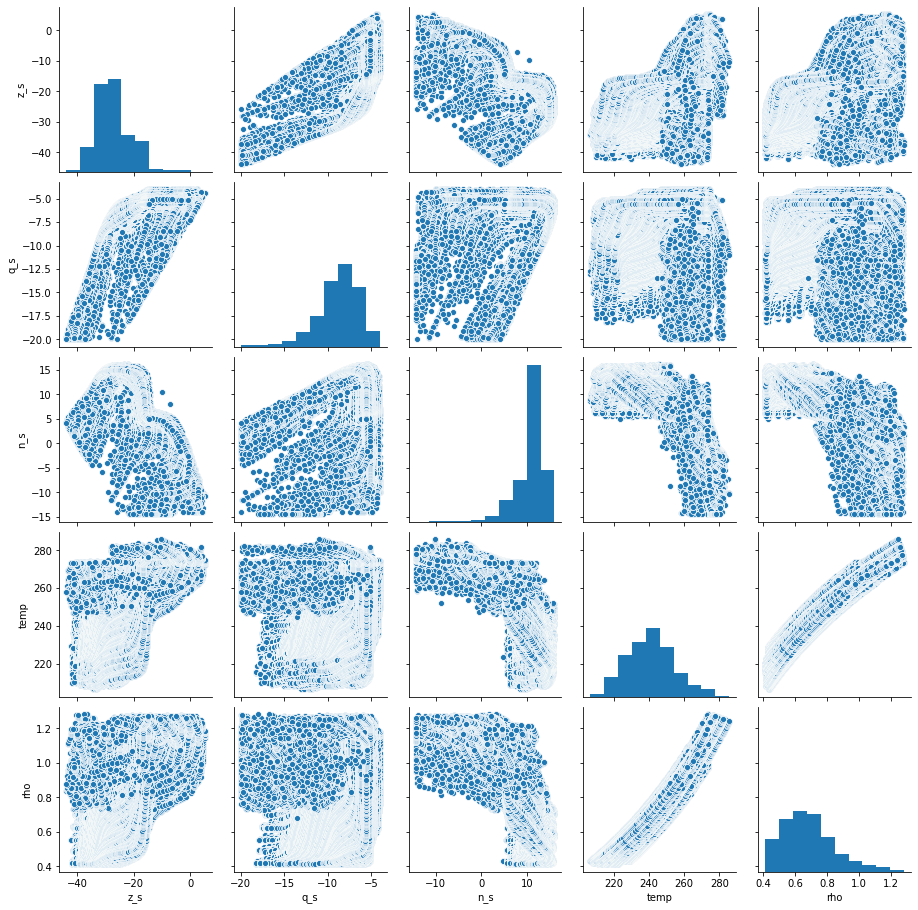

In [18]:
sns.pairplot(dataset_train[["z_s","q_s","n_s","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()
train_dataset5 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()
test_dataset5 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()
val_dataset5 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['temp','rho'], axis=1)
train_dataset2 = train_dataset2.drop(['temp'], axis=1)
#train_dataset3 = train_dataset3.drop(['ssi'], axis=1)
#train_dataset4 = train_dataset4.drop(['zi'], axis=1)
#train_dataset5 = train_dataset5.drop(['qs'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['temp','rho'], axis=1)
test_dataset2 = test_dataset2.drop(['temp'], axis=1)
#test_dataset3 = test_dataset3.drop(['ssi'], axis=1)
#test_dataset4 = test_dataset4.drop(['zi'], axis=1)
#test_dataset5 = test_dataset5.drop(['qs'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['temp','rho'], axis=1)
val_dataset2 = val_dataset2.drop(['temp'], axis=1)
#val_dataset3 = val_dataset3.drop(['ssi'], axis=1)
#val_dataset4 = val_dataset4.drop(['zi'], axis=1)
#val_dataset5 = val_dataset5.drop(['qs'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("z_s")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min       25%        50%  \
q_s  1158769.0  -8.808176  2.446480 -19.999590 -9.998370  -8.475044   
n_s  1158769.0  10.717083  3.120036 -14.467842  9.879758  11.397380   

           75%       max  
q_s  -7.098734  -4.00540  
n_s  12.627149  16.08032

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("z_s")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min       25%        50%  \
q_s  1158769.0  -8.808176  2.446480 -19.999590 -9.998370  -8.475044   
n_s  1158769.0  10.717083  3.120036 -14.467842  9.879758  11.397380   
rho  1158769.0   0.685503  0.166531   0.412000  0.560000   0.665000   

           75%       max  
q_s  -7.098734  -4.00540  
n_s  12.627149  16.08032  
rho   0.773000   1.28100

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("z_s")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean        std         min         25%         50%  \
q_s   1158769.0   -8.808176   2.446480  -19.999590   -9.998370   -8.475044   
n_s   1158769.0   10.717083   3.120036  -14.467842    9.879758   11.397380   
temp  1158769.0  241.119125  13.432857  206.639999  231.380005  240.740005   
rho   1158769.0    0.685503   0.166531    0.412000    0.560000    0.665000   

             75%         max  
q_s    -7.098734   -4.005400  
n_s    12.627149   16.080320  
temp  249.419998  285.700012  
rho     0.773000    1.281000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [28]:
# pop does not work for multiple columns, use copy instead

labels = [ 'z_s' ]

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [31]:
train_labels.describe()

z_s
count  1.158769e+06
mean  -2.702151e+01
std    6.219386e+00
min   -4.394429e+01
25%   -3.116167e+01
50%   -2.810608e+01
75%   -2.381243e+01
max    5.226016e+00

In [32]:
train_dataset1.describe()

q_s           n_s
count  1.158769e+06  1.158769e+06
mean  -8.808176e+00  1.071708e+01
std    2.446480e+00  3.120036e+00
min   -1.999959e+01 -1.446784e+01
25%   -9.998370e+00  9.879758e+00
50%   -8.475044e+00  1.139738e+01
75%   -7.098734e+00  1.262715e+01
max   -4.005400e+00  1.608032e+01

In [33]:
train_dataset2.describe()

q_s           n_s           rho
count  1.158769e+06  1.158769e+06  1.158769e+06
mean  -8.808176e+00  1.071708e+01  6.855026e-01
std    2.446480e+00  3.120036e+00  1.665312e-01
min   -1.999959e+01 -1.446784e+01  4.120000e-01
25%   -9.998370e+00  9.879758e+00  5.600000e-01
50%   -8.475044e+00  1.139738e+01  6.650000e-01
75%   -7.098734e+00  1.262715e+01  7.730000e-01
max   -4.005400e+00  1.608032e+01  1.281000e+00

In [34]:
train_dataset3.describe()

q_s           n_s          temp           rho
count  1.158769e+06  1.158769e+06  1.158769e+06  1.158769e+06
mean  -8.808176e+00  1.071708e+01  2.411191e+02  6.855026e-01
std    2.446480e+00  3.120036e+00  1.343286e+01  1.665312e-01
min   -1.999959e+01 -1.446784e+01  2.066400e+02  4.120000e-01
25%   -9.998370e+00  9.879758e+00  2.313800e+02  5.600000e-01
50%   -8.475044e+00  1.139738e+01  2.407400e+02  6.650000e-01
75%   -7.098734e+00  1.262715e+01  2.494200e+02  7.730000e-01
max   -4.005400e+00  1.608032e+01  2.857000e+02  1.281000e+00

### Normalize the features

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [36]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s  1158769.0  6.356092e-07  1.0 -4.574496 -0.486492  0.136168  0.698735   
n_s  1158769.0 -5.122985e-07  1.0 -8.071998 -0.268370  0.218041  0.612193   

          max  
q_s  1.963137  
n_s  1.718966

In [37]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_s  1158769.0  6.356092e-07  1.0 -4.574496 -0.486492  0.136168  0.698735   
n_s  1158769.0 -5.122985e-07  1.0 -8.071998 -0.268370  0.218041  0.612193   
rho  1158769.0  5.033297e-08  1.0 -1.642350 -0.753628 -0.123116  0.525411   

          max  
q_s  1.963137  
n_s  1.718966  
rho  3.575890

In [38]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_s   1158769.0  6.356092e-07  1.0 -4.574496 -0.486492  0.136168  0.698735   
n_s   1158769.0 -5.122985e-07  1.0 -8.071998 -0.268370  0.218041  0.612193   
temp  1158769.0 -2.257172e-06  1.0 -2.566775 -0.725022 -0.028223  0.617953   
rho   1158769.0  5.033297e-08  1.0 -1.642350 -0.753628 -0.123116  0.525411   

           max  
q_s   1.963137  
n_s   1.718966  
temp  3.318794  
rho   3.575890

### Normalize the labels

In [39]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%        50%  \
z_s  1158769.0 -27.021515  6.219386 -43.944294 -31.161667 -28.106077   

           75%       max  
z_s -23.812429  5.226016

In [40]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [41]:
DNNstring='16x16x16'

def build_model_sigm(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [42]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(2,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [44]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.86986196],
       [-0.8697269 ],
       [-0.8696697 ],
       [-0.8695755 ],
       [-0.8694749 ],
       [-0.8693633 ],
       [-0.8692547 ],
       [-0.86915916],
       [-0.86893153],
       [-0.8688486 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [45]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [46]:
activ = "sigm"
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0319,  mae:0.1097,  mse:0.0319,  val_loss:0.0206,  val_mae:0.0928,  val_mse:0.0206,  
.....................................

Text(0, 0.5, 'MAE')

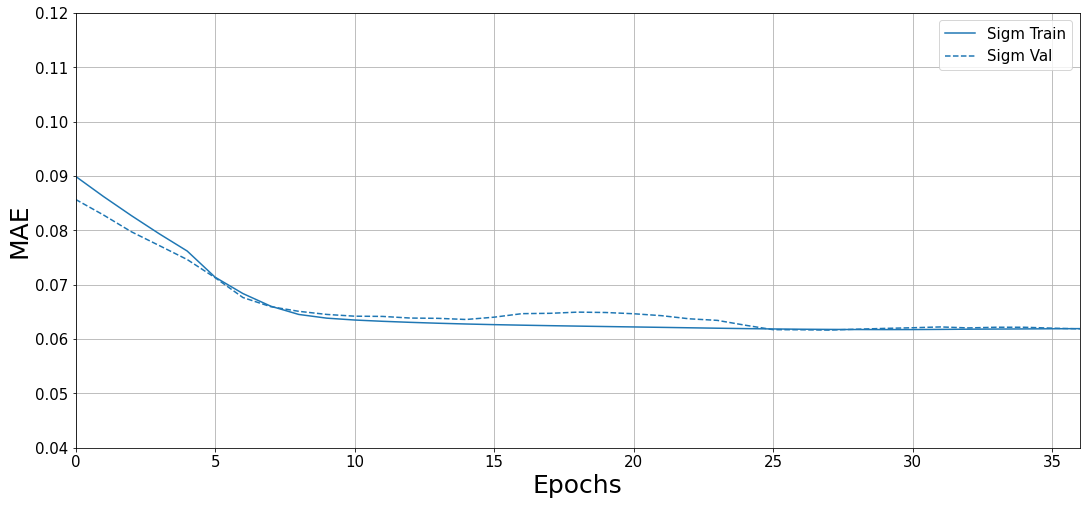

In [47]:
histories['sigm'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04,0.12])
plt.ylabel('MAE')

In [48]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0266,  mae:0.0961,  mse:0.0266,  val_loss:0.0185,  val_mae:0.0928,  val_mse:0.0185,  
...............................................................................

Text(0, 0.5, 'MAE')

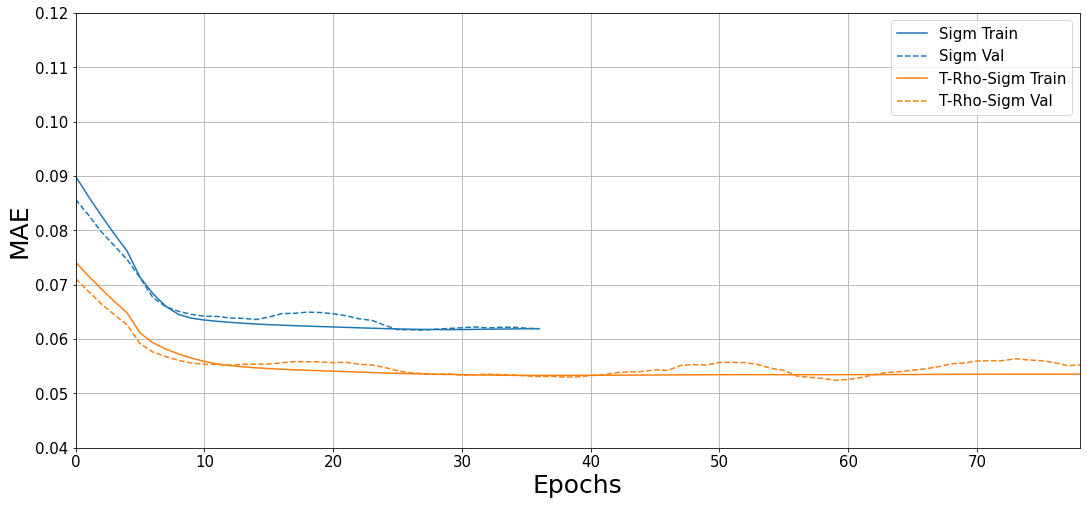

In [49]:
histories['T-rho-sigm'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.12])
plt.ylabel('MAE')

In [50]:
activ = "ReLU"
model4 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history4 = model4.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0132,  mae:0.0688,  mse:0.0132,  val_loss:0.0106,  val_mae:0.0642,  val_mse:0.0106,  
..............

Text(0, 0.5, 'MAE')

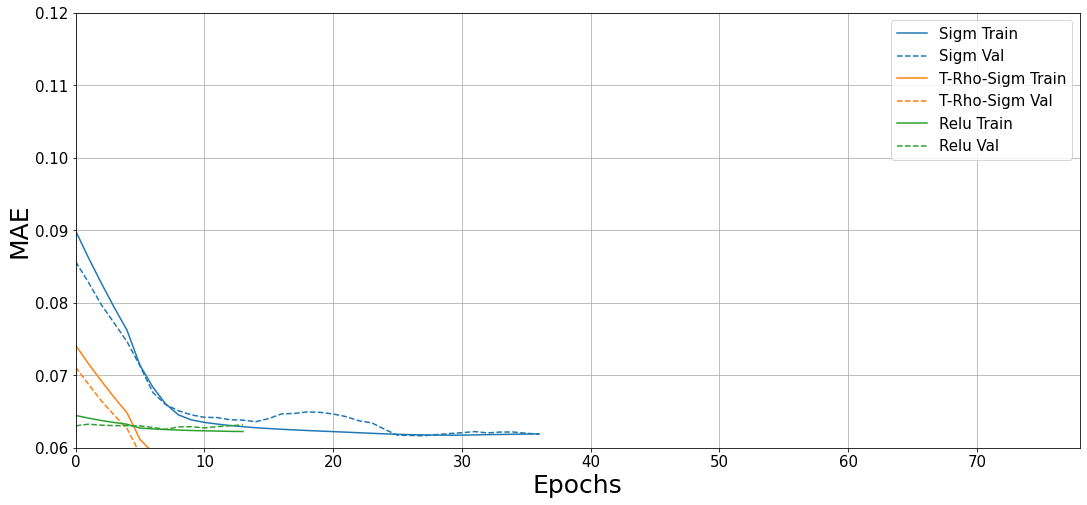

In [51]:
histories['ReLU'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.12])
plt.ylabel('MAE')

In [52]:
model5 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history5 = model5.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0117,  mae:0.0634,  mse:0.0117,  val_loss:0.0088,  val_mae:0.0534,  val_mse:0.0088,  
......................

Text(0, 0.5, 'MAE')

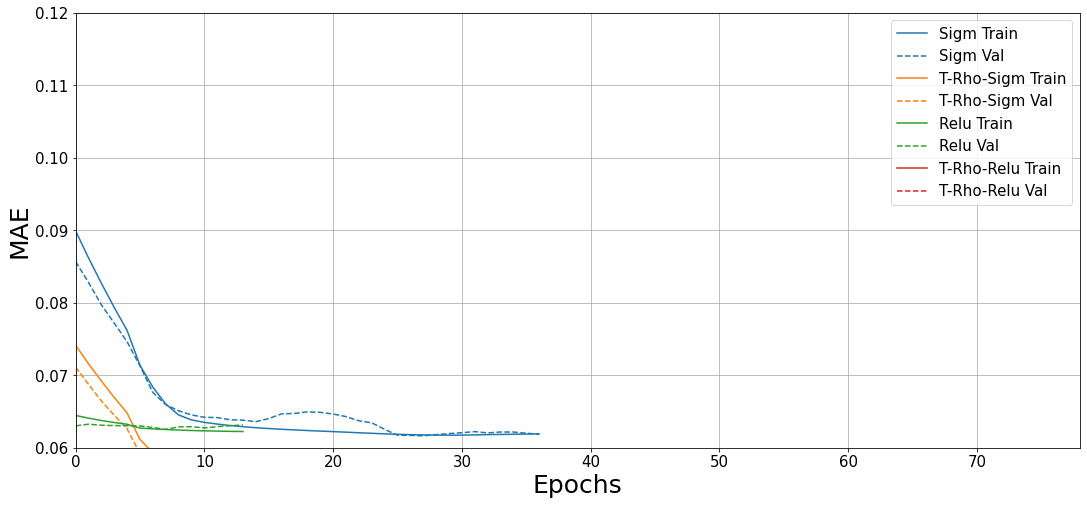

In [53]:
histories['T-rho-ReLU'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.12])
plt.ylabel('MAE')

In [54]:
activ = "ReLU_Adam"
model6 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history6 = model6.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0131,  mae:0.0687,  mse:0.0131,  val_loss:0.0105,  val_mae:0.0604,  val_mse:0.0105,  
..........................................

Text(0, 0.5, 'MAE')

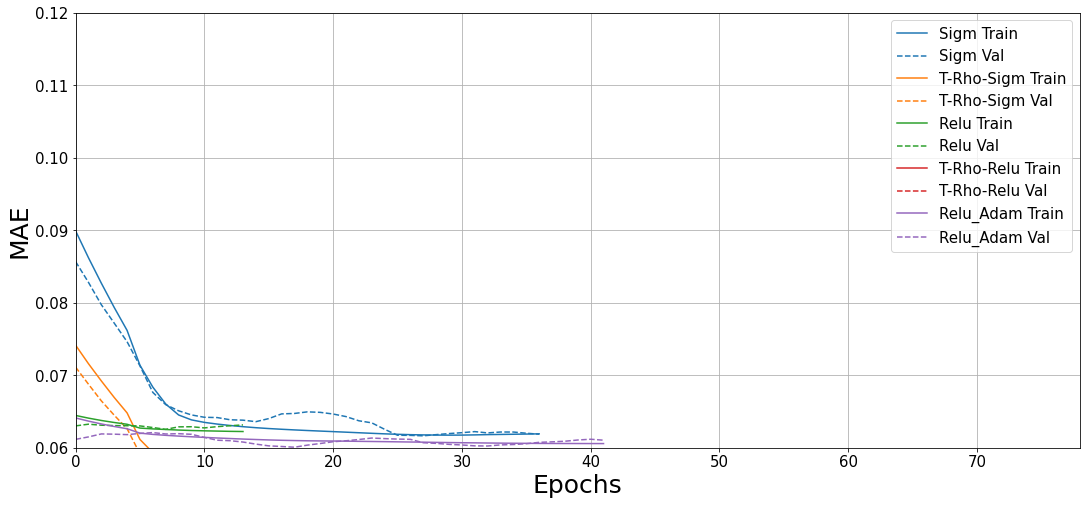

In [55]:
histories['ReLU_Adam'] = early_history6

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.12])
plt.ylabel('MAE')

In [56]:
model7 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history7 = model7.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0126,  mae:0.0631,  mse:0.0126,  val_loss:0.0086,  val_mae:0.0522,  val_mse:0.0086,  
.............................................

Text(0, 0.5, 'MAE')

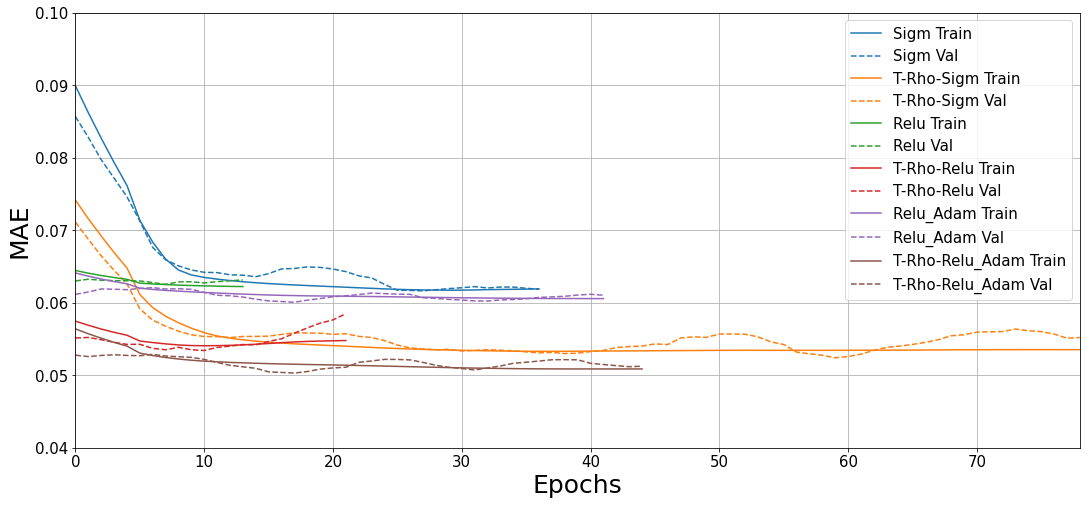

In [59]:
histories['T-rho-ReLU_Adam'] = early_history7

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.1])
plt.ylabel('MAE')

In [60]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

248745/248745 - 6s - loss: 0.0105 - mae: 0.0602 - mse: 0.0105
Testing set for model 1, Mean Abs Error:    0.06018


In [61]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

248745/248745 - 6s - loss: 0.0084 - mae: 0.0519 - mse: 0.0084
Testing set for model 3, Mean Abs Error:              0.05187


In [62]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

248745/248745 - 6s - loss: 0.0105 - mae: 0.0615 - mse: 0.0105
Testing set for model 4, Mean Abs Error:              0.06147


In [63]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

248745/248745 - 6s - loss: 0.0080 - mae: 0.0529 - mse: 0.0080
Testing set for model 5, Mean Abs Error:              0.05291


In [64]:
loss6, mae6, mse6 = model6.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 6, Mean Abs Error: {:20.5f}".format(mae6))

248745/248745 - 6s - loss: 0.0102 - mae: 0.0591 - mse: 0.0102
Testing set for model 6, Mean Abs Error:              0.05911


In [65]:
loss7, mae7, mse7 = model7.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 7, Mean Abs Error: {:20.5f}".format(mae7))

248745/248745 - 6s - loss: 0.0075 - mae: 0.0494 - mse: 0.0075
Testing set for model 7, Mean Abs Error:              0.04940


In [66]:
mae = [ mae1, mae3, mae4, mae5, mae6, mae7 ]
mae

[0.060178425, 0.05187339, 0.06146822, 0.052910738, 0.059111048, 0.04939632]

In [67]:
mse = [ mse1, mse3, mse4, mse5, mse6, mse7 ]
mse

[0.010464358, 0.008350439, 0.010482238, 0.008022223, 0.010189311, 0.007522597]

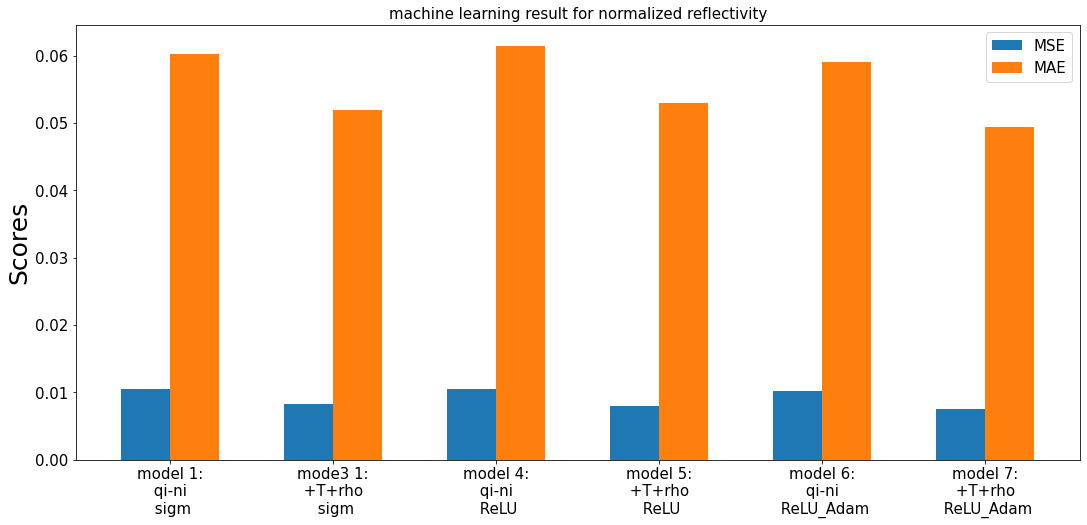

In [68]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1:\n qi-ni \n sigm',
 'mode3 1:\n +T+rho \n sigm',
 'model 4:\n qi-ni \n ReLU',
 'model 5:\n +T+rho \n ReLU',
 'model 6:\n qi-ni \n ReLU_Adam',
 'model 7:\n +T+rho \n ReLU_Adam' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized reflectivity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [69]:
test_true_z  = np.exp(test_labels.pop('z_s'))

In [70]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [71]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=["z_s"])

In [72]:
p1.describe()

z_s
count  248745.000000
mean       -0.003523
std         0.998234
min        -2.455558
25%        -0.670965
50%        -0.170142
75%         0.497130
max         4.888462

In [73]:
train_labels_stats

count       mean       std        min        25%        50%  \
z_s  1158769.0 -27.021515  6.219386 -43.944294 -31.161667 -28.106077   

           75%       max  
z_s -23.812429  5.226016

In [74]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [75]:
test_predict1.describe()

z_s
count  2.487450e+05
mean   5.011128e-03
std    1.593344e-01
min    4.286801e-19
25%    2.833993e-14
50%    6.384750e-13
75%    4.050196e-11
max    2.942121e+01

In [76]:
test_predict1_z  = test_predict1['z_s']

In [77]:

p2 = pd.DataFrame(data=model4.predict(normed_test_data1), columns=["z_s"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_z = test_predict2['z_s']

In [78]:

p3 = pd.DataFrame(data=model6.predict(normed_test_data1), columns=["z_s"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_z = test_predict3['z_s']

### Maybe the ordering of the arrays is different? 

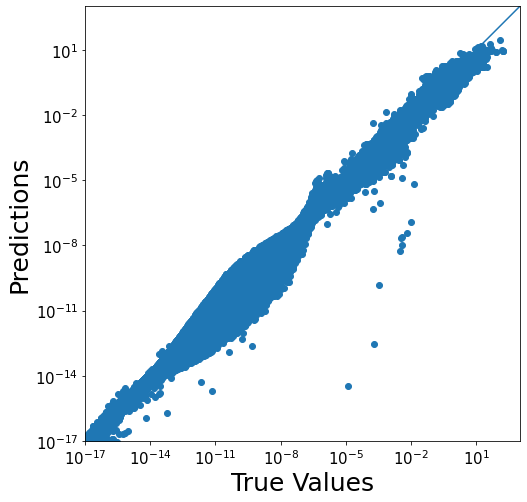

In [86]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-17, 1e3

a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict1_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

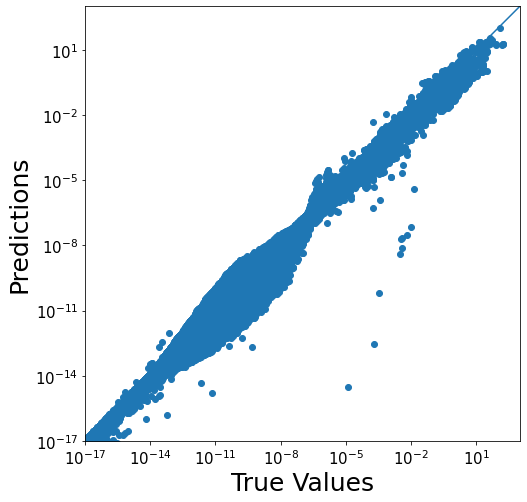

In [87]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict2_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

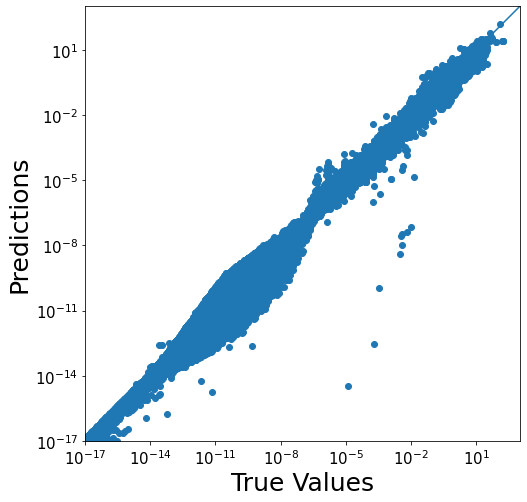

In [88]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict3_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [89]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [90]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [91]:
features = 'q_snow, n_snow'
labels   = 'z_snow'
logtransform = np.array([True, True], dtype=bool)
save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/refl_snow_model1_'+version+'.nc')
save2netcdf(model4,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/refl_snow_model4_'+version+'.nc')
save2netcdf(model6,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/refl_snow_model6_'+version+'.nc')

Saving model to saved_model_v2/refl_snow_model1_04.nc
  Features:   q_snow, n_snow
  Labels:     z_snow
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (2, 16), Activation: sigmoid
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/refl_snow_model4_04.nc
  Features:   q_snow, n_snow
  Labels:     z_snow
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (2, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/refl_snow_model6_04.nc
 

In [92]:
features = 'q_snow, n_snow, T, rho'
logtransform = np.array([True, True, False, False], dtype=bool)
save2netcdf(model3,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/refl_snow_model3_'+version+'.nc')
save2netcdf(model5,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/refl_snow_model5_'+version+'.nc')
save2netcdf(model7,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/refl_snow_model7_'+version+'.nc')

Saving model to saved_model_v2/refl_snow_model3_04.nc
  Features:   q_snow, n_snow, T, rho
  Labels:     z_snow
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: sigmoid
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/refl_snow_model5_04.nc
  Features:   q_snow, n_snow, T, rho
  Labels:     z_snow
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/refl_sno